In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils import data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import math
from torch.utils.data import DataLoader, TensorDataset, random_split


from torch.nn import Conv2d
from torch import optim

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


In [2]:
import pandas as pd
import pickle

df = pd.read_csv('MoS2_activities_substrate.csv')

with open("MoS2_spmImage_ids", "rb") as fp:   # Unpickling
  MoS2_spmImage_ids = pickle.load(fp)
print(df.keys())
sampleLabel = df['sampleLabel']
sampleId = df['sampleId'].tolist()
Temperature = df['T']#.to_numpy()
#Temperature = Temperature.reshape(len(Temperature),1)
Substrate = df['substrate'].tolist()
Time = df['time']

sampleLabel_image = MoS2_spmImage_ids['sampleLabel']
sampleId_image = MoS2_spmImage_ids['sampleId']
sampleId_image = [int(item) for item in sampleId_image]
image = np.array(MoS2_spmImage_ids['image'])
print(len(Substrate))
print(Temperature.shape)
print(image.shape)

print(type(sampleId))
print((sampleId[:10]))
print(type(sampleId_image))
print((sampleId_image[:10]))

Index(['Unnamed: 0', 'sampleLabel', 'sampleId', 'time', 'T', 'P', 'substrate'], dtype='object')
365
(365,)
(368, 224, 224)
<class 'list'>
[8620, 10190, 10191, 10213, 10214, 10214, 10215, 10215, 10215, 10216]
<class 'list'>
[8620, 10190, 10191, 10213, 10214, 10214, 10215, 10215, 10215, 10216]


In [14]:
print(len(sampleId))
from collections import Counter
unique_sampleId = []
unique_sampleLabel = []
unique_Temp = []
unique_Sub = []
unique_Time = []
for index, item in enumerate(sampleId):
    if item not in unique_sampleId:
        unique_sampleId.append(item)
        unique_sampleLabel.append(sampleLabel[index])
        unique_Temp.append(Temperature[index])
        unique_Sub.append(Substrate[index])
        unique_Time.append(Time[index])
print(len(unique_sampleId))
print(Counter(unique_Temp))
print(Counter(Temperature))

365
265
Counter({950.0: 130, 1000.0: 103, 900.0: 29, nan: 1, 600.0: 1, nan: 1})
Counter({950.0: 209, 1000.0: 116, 900.0: 35, 600.0: 2, nan: 1, nan: 1, nan: 1})


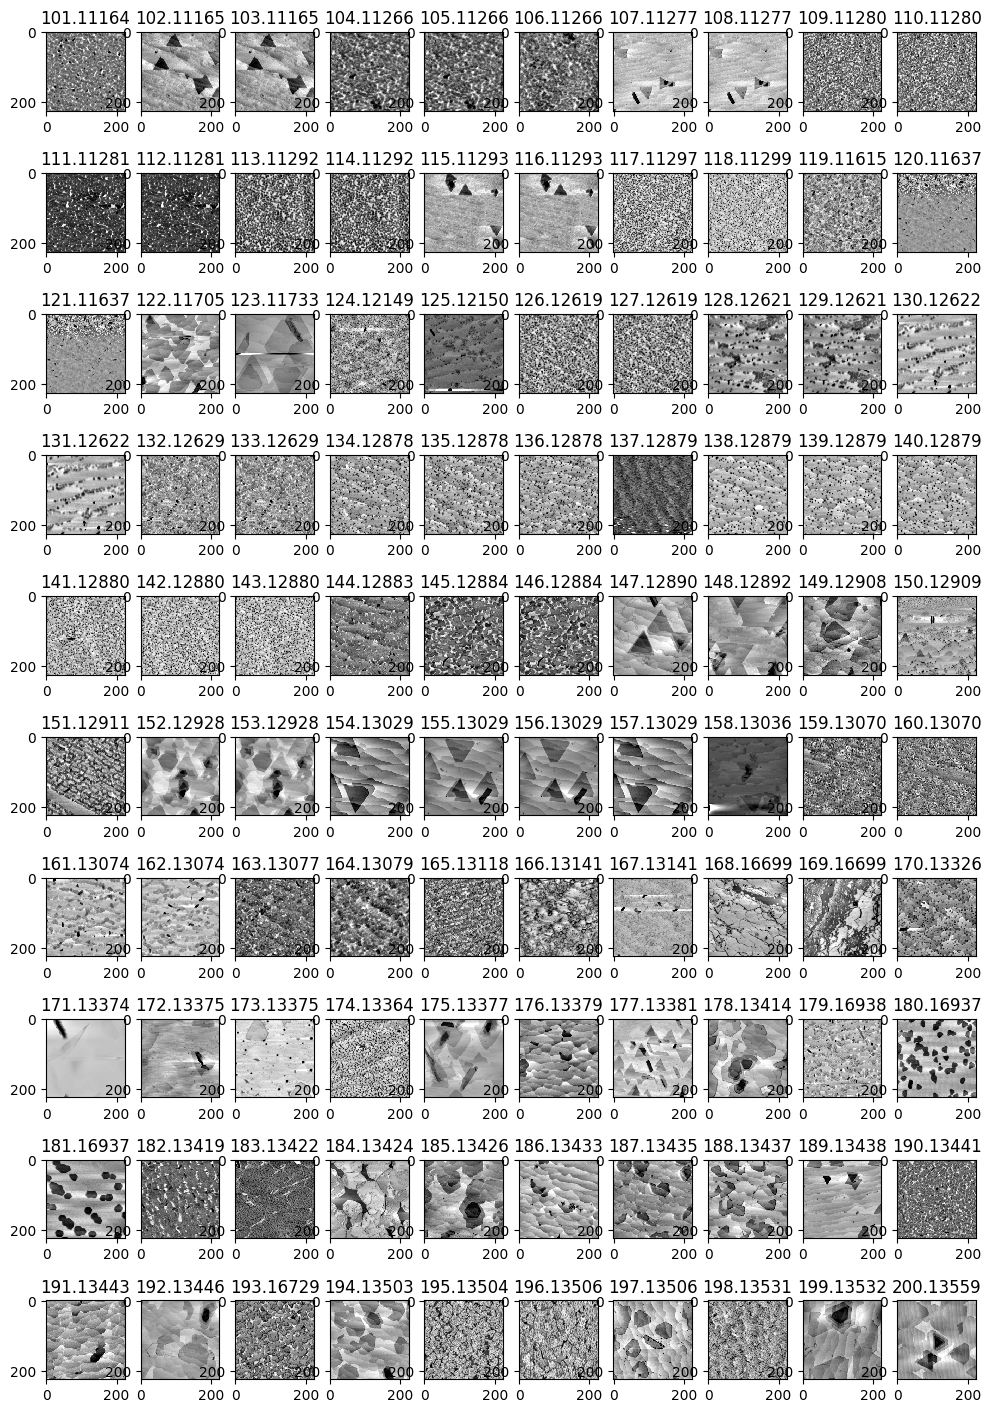

In [12]:
fig = plt.figure(figsize=(12, 18))

for i in range(100, 200):
    #sub = fig.add_subplot(64, 1, i + 1)
    sub = fig.add_subplot(10, 10, i + 1-100)
    sub.imshow(image[i], interpolation='nearest',cmap='binary')
    sub.set_title(f'{i+1}.{sampleId[i]}')

#### {'c-Sapphire': 163, 'AlN ': 4, 'Al2O3': 4, 'Scored c-Al2O3': 2, 'Al2O3 c-sapphire': 1, 'Al2O3 c-plane': 135, 'Al2O3 M-plane': 10, 'Al2O3 A-plane': 10, 'Al2O3 on Al2O3': 8, 'C-Al2O3 c-plane': 17, 'Al2O3 c-plane to A': 1}

In [3]:
SampleId_temp2 = []
#substrate_significant = ['c-Sapphire', 'Al203 c-plane', 'Al203 M-plane', 'Al203 A-plane', 'Al203 on Al203', 'C-Al203 c-plane', 'Al203 c-plane to A']
substrate_significant = ['c-Sapphire', 'Al2O3 c-plane', 'Al2O3 M-plane', 'Al2O3 A-plane','C-Al2O3 c-plane']
MoS2_spmImages_ids2 = {'sampleLabel': [], 'sampleId': [], 'image': []}
MoS2_activities_substrate2 = {'sampleLabel': [], 'sampleId': [], 'T': [], 'time': [], 'substrate': []}

for index, item in enumerate(sampleId_image):
    if item !=11615:
        for index2, item2 in enumerate(sampleId_image):
            if  Substrate[index2] in substrate_significant and not np.isnan(Temperature[index2]) and Temperature[index2] !=600.0:
                if item == item2:

                    MoS2_spmImages_ids2['sampleLabel'].append(sampleLabel_image[index])
                    MoS2_spmImages_ids2['sampleId'].append(item)
                    MoS2_spmImages_ids2['image'].append(image[index])

                    MoS2_activities_substrate2['sampleLabel'].append(sampleLabel[index2])
                    MoS2_activities_substrate2['sampleId'].append(item2)
                    MoS2_activities_substrate2['T'].append(Temperature[index2])
                    MoS2_activities_substrate2['time'].append(Time[index2])
                    MoS2_activities_substrate2['substrate'].append(Substrate[index2])

                    if item ==11615:
                        print('yes')
                    break

print(len(MoS2_spmImages_ids2['sampleId']))

Temperature2 = MoS2_activities_substrate2['T']
#for index3, item3 in enumerate(Temperature):
    

347


In [4]:
with open("MoS2_spmImages_ids2", "wb") as fp:   #Pickling
  pickle.dump(MoS2_spmImages_ids2, fp)

with open("MoS2_activities_substrate2", "wb") as fp:   #Pickling
  pickle.dump(MoS2_activities_substrate2, fp)
  

In [3]:
def is_nan(value):
    return math.isnan(float(value))

SampleId_temp2 = []
#substrate_significant = ['c-Sapphire', 'Al203 c-plane', 'Al203 M-plane', 'Al203 A-plane', 'Al203 on Al203', 'C-Al203 c-plane', 'Al203 c-plane to A']
substrate_significant = ['c-Sapphire', 'Al2O3 c-plane', 'Al2O3 M-plane', 'Al2O3 A-plane','C-Al2O3 c-plane']
targets = [900.0, 950.0, 1000.0]
MoS2_Analysis_Processed_Data = []
count = 0
for index, item in enumerate(sampleId_image):
    dicts = {}
    if item !=11615:
        for index2, item2 in enumerate(sampleId):
            if ~np.isnan(Temperature[index2]) and Temperature[index2] !=600.0:
                
                #if # ~np.isnan(float(Temperature[index2])) and Temperature[index2] !=600.0:# and :# not math.isnan(float('nan')):
                if item == item2:
                    count += 1

                    dicts['sampleLabel'] = sampleLabel_image[index]
                    dicts['sampleId'] = item
                    dicts['image'] = image[index]
                    dicts['T'] = Temperature[index2]
                    dicts['time'] = Time[index2]
                    dicts['substrate'] = Substrate[index2]
                    MoS2_Analysis_Processed_Data.append(dicts)
                    if item ==11615:
                        print('yes')
                    break
    
print(len(MoS2_Analysis_Processed_Data))
print(count)
#Temperature2 = MoS2_activities_substrate2['T']
#for index3, item3 in enumerate(Temperature):
    

359
359


In [4]:
with open("MoS2_Analysis/Data/MoS2_Analysis_Processed_Data1", "wb") as fp:   #Pickling
  pickle.dump(MoS2_Analysis_Processed_Data, fp)

df = pd.DataFrame(MoS2_Analysis_Processed_Data)
T = df['T']
print(T)

0      1000.0
1       900.0
2       900.0
3       900.0
4       900.0
        ...  
354    1000.0
355    1000.0
356    1000.0
357    1000.0
358    1000.0
Name: T, Length: 359, dtype: float64


In [53]:
data_image = np.array([np.array(item) for item in df['image']])
print(data_image.shape)

(359, 224, 224)


# Data Used: 1 image per unique SampleId

In [16]:
def is_nan(value):
    return math.isnan(float(value))

SampleId_temp2 = []
#substrate_significant = ['c-Sapphire', 'Al203 c-plane', 'Al203 M-plane', 'Al203 A-plane', 'Al203 on Al203', 'C-Al203 c-plane', 'Al203 c-plane to A']
substrate_significant = ['c-Sapphire', 'Al2O3 c-plane', 'Al2O3 M-plane', 'Al2O3 A-plane','C-Al2O3 c-plane']
targets = [900.0, 950.0, 1000.0]
MoS2_Analysis_Processed_Data = []
count = 0
for index, item in enumerate(unique_sampleId):
    dicts = {}
    if item !=11615:
        for index2, item2 in enumerate(sampleId_image):
            if ~np.isnan(unique_Temp[index]) and unique_Temp[index] !=600.0:
                
                #if # ~np.isnan(float(Temperature[index2])) and Temperature[index2] !=600.0:# and :# not math.isnan(float('nan')):
                if item == item2:
                    count += 1

                    dicts['sampleLabel'] = unique_sampleLabel[index]
                    dicts['sampleId'] = item
                    dicts['image'] = image[index2]
                    dicts['T'] = unique_Temp[index]
                    dicts['time'] = unique_Time[index]
                    dicts['substrate'] = unique_Sub[index]

                    MoS2_Analysis_Processed_Data.append(dicts)
                    if item ==11615:
                        print('yes')
                    break
    
print(len(MoS2_Analysis_Processed_Data))
print(count)
#Temperature2 = MoS2_activities_substrate2['T']
#for index3, item3 in enumerate(Temperature):
    

262
262


In [21]:
with open("MoS2_Analysis/Data/MoS2_Analysis_Processed_Data2", "wb") as fp:   #Pickling
  pickle.dump(MoS2_Analysis_Processed_Data, fp)

df = pd.DataFrame(MoS2_Analysis_Processed_Data)
T = df['T']
sub = df['substrate']
time = df['time']
print(T)

0      1000.0
1       900.0
2       900.0
3       900.0
4       900.0
        ...  
257    1000.0
258    1000.0
259    1000.0
260    1000.0
261    1000.0
Name: T, Length: 262, dtype: float64
